In [1]:
# -------------------------------------------------------
# Project 1
# Sagar Shivaji Vetal - 40071979
# Himanshu Kohli - 40070839
# For COMP 6721 Section FJ – Fall 2019
# -------------------------------------------------------

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
from matplotlib.lines import Line2D 
import numpy as np
import operator
import collections
import heapq
import math
import datetime


class Node:
    """
    This class is used to hold coordinates of each corner of the grid cells
    It also holds the cost from start point to this point, heuristic value, 
    parent node and its children.
    """
    
    def __init__(self, x, y, g):
        """
        Parameters
        ----------
        x : float
            The x cordinate of node
        y : float
            The y cordinate of node
        g : float
            The cost from start point to this point
        """
        self.x = x
        self.y = y
        self.g = g
        self.h = 0
        self.f = self.g + self.h
        self.parent = None
        self.childNodes = []
    
    
    def __lt__(self, other):
        """
        This method is used by heapq to sort node based on priority.
        Parameters
        ----------
        self : Node object
            The self node
        other : Node object
            The node with which self node to be compared 
        """
        return self.h < other.h
    
    
class UserMap:
    """
    This class is used to hold coordinates of map area, grid cell size, threshold,
    start and end point, total polygons and blocked polygons of map grid.
    """
    
    def __init__(self):
        self.xmin = 0.0
        self.ymin = 0.0
        self.xmax = 0.0
        self.ymax = 0.0
        self.cellsize = 0.0
        self.threshold = 0
        self.polygons = []
        self.blockedPolygons = []
        self.nodes = dict()
        self.startNode = None
        self.goalNode = None


def is_inside_area(x, y, userMap):
    """
    This method is used to check whether given coordinate belong to map area.
    Parameters
    ----------
    x : float
        The x cordinate of node
    x : float
        The y cordinate of node
    userMap : object
        The object of usermap class
    """
    if(userMap.xmin <= x and userMap.ymin <= y and x <= userMap.xmax and y <= userMap.ymax) :
        return True
    else:
        return False


def is_inside_polygon(x, y, xmin,ymin, xmax, ymax):
    """
    This method is used to check whether given coordinate belong to area of polygon.
    Parameters
    ----------
    x : float
        The x cordinate of node
    x : float
        The y cordinate of node
    xmin : float
        The xmin cordinate of polygon
    ymin : float
        The ymin cordinate of polygon
    xmax : float
        The xmax cordinate of polygon
    ymax : float
        The ymax cordinate of polygon
    """
    if(xmin <= x and ymin <= y and x <= xmax and y <= ymax) :
        return True
    else:
        return False


def get_edge_cost(x1, y1, x2, y2, blockedPolygons, isDiagonal, edge) :
    """
    This method is used to get edge cost from given point.
    Parameters
    ----------
    x1 : float
        The x cordinate of from point
    y1 : float
        The y cordinate of from point
    x2 : float
        The x cordinate of to point
    y2 : float
        The y cordinate of to point
    blockedPolygons : object list
        The list of object of blocked polygon
    isDiagonal : bool
        The boolean flag to chech whether edge is diagonal or not
    edge : str
        String value to denote edge type
    """
    fromPoint = Point(x1, y1)
    toPoint = Point(x2, y2)
    count = 0
    for i in range(len(blockedPolygons)):
        
        if (edge == "T" and ((blockedPolygons[i].bounds[0] == x1 and blockedPolygons[i].bounds[1] == y1 and
            blockedPolygons[i].bounds[0] == x2 and blockedPolygons[i].bounds[3] == y2) or
            (blockedPolygons[i].bounds[2] == x1 and blockedPolygons[i].bounds[1] == y1 and
            blockedPolygons[i].bounds[2] == x2 and blockedPolygons[i].bounds[3] == y2))):
            count += 1
        
        if (edge == "R" and ((blockedPolygons[i].bounds[0] == x1 and blockedPolygons[i].bounds[1] == y1 and
            blockedPolygons[i].bounds[2] == x2 and blockedPolygons[i].bounds[1] == y2) or
            (blockedPolygons[i].bounds[0] == x1 and blockedPolygons[i].bounds[3] == y1 and
            blockedPolygons[i].bounds[2] == x2 and blockedPolygons[i].bounds[3] == y2))):
            count += 1
        
        if (edge == "B" and ((blockedPolygons[i].bounds[0] == x1 and blockedPolygons[i].bounds[3] == y1 and
            blockedPolygons[i].bounds[0] == x2 and blockedPolygons[i].bounds[1] == y2) or
            (blockedPolygons[i].bounds[2] == x1 and blockedPolygons[i].bounds[3] == y1 and
            blockedPolygons[i].bounds[2] == x2 and blockedPolygons[i].bounds[1] == y2))):
            count += 1
        
        if (edge == "L" and ((blockedPolygons[i].bounds[2] == x1 and blockedPolygons[i].bounds[1] == y1 and
            blockedPolygons[i].bounds[0] == x2 and blockedPolygons[i].bounds[1] == y2) or
            (blockedPolygons[i].bounds[2] == x1 and blockedPolygons[i].bounds[3] == y1 and
            blockedPolygons[i].bounds[0] == x2 and blockedPolygons[i].bounds[3] == y2))):
            count += 1
        
        if (edge == "TRD" and (blockedPolygons[i].bounds[0] == x1 and blockedPolygons[i].bounds[1] == y1 and
            blockedPolygons[i].bounds[2] == x2 and blockedPolygons[i].bounds[3] == y2)):
            count += 1
        
        if (edge == "BRD" and (blockedPolygons[i].bounds[0] == x1 and blockedPolygons[i].bounds[3] == y1 and
            blockedPolygons[i].bounds[2] == x2 and blockedPolygons[i].bounds[1] == y2)):
            count += 1
        
        if (edge == "BLD" and (blockedPolygons[i].bounds[2] == x1 and blockedPolygons[i].bounds[3] == y1 and
            blockedPolygons[i].bounds[0] == x2 and blockedPolygons[i].bounds[1] == y2)):
            count += 1
        
        if (edge == "TLD" and (blockedPolygons[i].bounds[2] == x1 and blockedPolygons[i].bounds[1] == y1 and
            blockedPolygons[i].bounds[0] == x2 and blockedPolygons[i].bounds[3] == y2)):
            count += 1
        
        if count == 2 and not(isDiagonal):
            return 0
        
        if(count == 1 and isDiagonal):
            return 0           
    
    if(count == 0 and not(isDiagonal)):
        return 1.0
    if(count == 0 and isDiagonal):
        return 1.5
    if(count == 1 and not(isDiagonal)):
        return 1.3


def is_goal(node, goalNode):
    """
    This method is used to check whether given node is goal node or not
    Parameters
    ----------
    node : object
        The object of current Node
    goalNode : object
        The object of goal Node
    """
    if node.x == goalNode.x and node.y == goalNode.y :
        return True
    else :
        return False


def get_index(nodeList, node):
    """
    This method is used to the index of node in given node list
    Parameters
    ----------
    nodeList : list
        The list of Node
    node : object
        The object of current Node
    """
    for i in range(len(nodeList)):
        if nodeList[i][1].x == node.x and nodeList[i][1].y == node.y :
            return i
    return -1


def is_present(nodeList, node):
    """
    This method is used to check wether given node present in given node list
    Parameters
    ----------
    nodeList : list
        The list of Node
    node : object
        The object of current Node
    """
    for i in range(len(nodeList)):
        if nodeList[i].x == node.x and nodeList[i].y == node.y :
            return True
    return False


def heuristic(node, goalNode, scale):
    """
    This method estimates cost from current node to goal node
    Parameters
    ----------
    node : object
        The object of current Node
    goalNode : object
        The object of goal Node
    scale : float
        The cost scale
    """
    x_dist = np.ceil(abs(node.x - goalNode.x) / scale)
    y_dist = np.ceil(abs(node.y - goalNode.y) / scale)
    total_dist = x_dist + y_dist
    temp = (node.y + ((node.x+1)/2));
    hash_value = node.x + (temp ** 2);
    return total_dist + hash_value


def a_start_algorithm(userMap):
    """
    This alogrithm finds the optimal path if exist, based on given heuristic
    Parameters
    ----------
    userMap : object
        The object of userMap
    """
    openList = []
    closeList = []
    isPathFound = False
    heapq.heappush(openList, (0, userMap.startNode))
    start = datetime.datetime.now()
    while len(openList) > 0 :
        diff = datetime.datetime.now()-start
        if (int(diff.total_seconds()) > 10):
            break;
            
        currentNode = heapq.heappop(openList)[1]
        
        if is_goal(currentNode, userMap.goalNode):
            isPathFound = True
            closeList.append(currentNode)
            break
        
        for node in currentNode.childNodes:
            
            if is_present(closeList, node) :
                continue
            
            if ((currentNode.x == userMap.xmin and node.x == userMap.xmin) or
                (currentNode.x == userMap.xmax and node.x == userMap.xmax) or
                (currentNode.y == userMap.ymin and node.y == userMap.ymin) or
                (currentNode.y == userMap.ymax and node.y == userMap.ymax)) :
                    continue
            
            nextNode = userMap.nodes[str(node.x) + "," + str(node.y)]
            nextNode.g = node.g + currentNode.g
            nextNode.h = heuristic(nextNode, userMap.goalNode, userMap.cellsize)
            nextNode.f = nextNode.g + nextNode.h
            nextNode.parent = currentNode
            
            index = get_index(openList, node)
            if index >= 0 and openList[index][1].f > nextNode.f :
                openList[index] = (nextNode.f, nextNode)
            
            if index == -1 :
                heapq.heappush(openList, (nextNode.f, nextNode))
            
        closeList.append(currentNode)
    return isPathFound, closeList



Enter grid cell size : 0.002
Enter threshold : 80

1. Normal Map file
2. CSV Map file
Enter your choice: 2

Enter longitude and latitude of start point : -73.59 45.49
Enter longitude and latitude of end point : -73.55 45.53

Reading Crime data...

Total Crimes 18451
Mean :  43.930952380952384
Median :  31.0
Standard Deviation :  47.55465521298944

Creating Map grid...
24	17	5	4	0	0	0	0	0	0	0	0	0	29	22	56	28	36	47	36
6	4	0	3	0	0	0	0	0	0	0	0	0	0	83	77	16	64	68	31
46	28	0	11	34	185	1	0	0	0	0	0	0	31	52	67	30	46	12	33
93	81	64	10	27	9	35	0	0	0	0	4	0	90	23	48	71	61	24	22
107	100	156	110	18	49	5	23	8	53	0	0	39	0	83	54	97	51	61	0
28	97	149	163	55	44	10	15	10	22	15	0	58	147	23	91	24	38	24	82
14	44	81	52	273	110	0	0	44	125	9	21	69	72	68	17	49	9	48	5
16	24	72	84	56	186	53	25	148	89	55	2	199	43	12	75	34	105	2	40
5	44	116	45	95	101	24	27	111	28	70	128	72	37	136	28	41	9	75	7
6	12	44	75	98	178	0	97	129	164	68	93	136	57	30	66	49	0	8	36
10	35	27	19	3	17	187	157	90	54	52	176	57	45	60	37	32	0	21	0
43	6	2

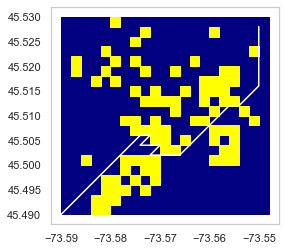

In [2]:
userMap = UserMap()

userMap.cellsize = float(input("Enter grid cell size : "))
userMap.threshold = float(input("Enter threshold : "))

choice = 0
while (choice != 1 and choice != 2):
    print("\n1. Normal Map file")
    print("2. CSV Map file")
    choice = int(input("Enter your choice: "))

df = pd.DataFrame()
if(choice == 1):
    points = gpd.read_file('crime_dt.shp')
    # userMap.xmin, userMap.ymin, userMap.xmax, userMap.ymax = -73.59, 45.49, -73.55, 45.53
    userMap.xmin, userMap.ymin, userMap.xmax, userMap.ymax = points.total_bounds
    dataframe = points.geometry
    df['long'] = dataframe.geometry.x
    df['lat'] = dataframe.geometry.y
else :
    userMap.xmin, userMap.ymin = [float(x) for x in input("\nEnter longitude and latitude of start point : ").split()]
    userMap.xmax, userMap.ymax = [float(x) for x in input("Enter longitude and latitude of end point : ").split()]
    csvdf = pd.read_csv('mtl_crime.csv', delimiter=',', encoding='latin-1')
    
    cleaned_df = csvdf[(csvdf.LONGITUDE >= userMap.xmin) & (csvdf.LONGITUDE <= userMap.xmax) & (csvdf.LATITUDE >= userMap.ymin) & (csvdf.LATITUDE <= userMap.ymax)]
    df['long'] = cleaned_df.LONGITUDE
    df['lat'] = cleaned_df.LATITUDE
    

print("\nReading Crime data...")
group_value = df.groupby(['lat','long']).size().reset_index(name='counts')
group_value.sort_values(['long','lat'],axis=0, ascending=True, inplace=True)
# print(group_value)

endPoint = Point(userMap.xmax, userMap.ymax)
startPoint = Point(userMap.xmin, userMap.ymin)

columns = int(np.ceil(abs(userMap.xmax - userMap.xmin) / userMap.cellsize))
rows = int(np.ceil(abs(userMap.ymax - userMap.ymin) / userMap.cellsize))

# print(rows)
# print(columns)

x1 = userMap.xmin
x2 = userMap.xmin + userMap.cellsize

for x in range(columns):
    y1 = userMap.ymin
    y2 = userMap.ymin + userMap.cellsize
    for y in range(rows):
        userMap.polygons.append( Polygon([(x1,y1), (x2, y1), (x2, y2), (x1, y2)]) )
        y1 = y2
        y2 += userMap.cellsize
    x1 = x2
    x2 += userMap.cellsize

grid = gpd.GeoDataFrame({'geometry':userMap.polygons})
sns.set(style='whitegrid');
fig,ax = plt.subplots()

# plt.figure(figsize=(30,30))
ax.grid(False)
ax = grid.plot(ax=ax,alpha=1,color='navy',edgecolor='navy')

blockCrimeRate_dict = dict()
startNodeKey = ""
endNodeKey = ""

for i in range(len(userMap.polygons)):
    blockCrimeRate_dict[userMap.polygons[i].bounds] = [i, 0];
    xmin, ymin, xmax, ymax = userMap.polygons[i].bounds
    if len(startNodeKey)==0 and is_inside_polygon(startPoint.x, startPoint.y, xmin, ymin, xmax, ymax):
        startNodeKey = str(xmin) + "," + str(ymin)
    if len(endNodeKey)==0 and is_inside_polygon(endPoint.x, endPoint.y, xmin, ymin, xmax, ymax):
        endNodeKey = str(xmin) + "," + str(ymin)

# print("Start Point:", startNodeKey)
# print("End Point:", endNodeKey)

total_crimes= 0
for index, point in group_value.iterrows():
    for i in range(len(userMap.polygons)):
        xmin, ymin, xmax, ymax = userMap.polygons[i].bounds
        if is_inside_polygon(point.long, point.lat, xmin, ymin, xmax, ymax):
            blockCrimeRate_dict[userMap.polygons[i].bounds][1] += point.counts
            total_crimes += point.counts
            break

blockCrimeRate_dict = collections.OrderedDict(sorted(blockCrimeRate_dict.items(), key=lambda kv:kv[1][1], reverse=True))

crime_list = [item[1] for item in list(blockCrimeRate_dict.values())]
print("\nTotal Crimes", int(total_crimes))

mean = np.array(crime_list).mean()
print("Mean : ", mean)

median = np.median(crime_list)
print("Median : ", median)

stdDev = np.std(crime_list)
print("Standard Deviation : ", stdDev)

print("\nCreating Map grid...")

thresholdIndex = int(np.ceil(len(blockCrimeRate_dict) * (100 - userMap.threshold) / 100))
# print(thresholdIndex)

# crimeThreshold = list(blockCrimeRate_dict.values())[thresholdIndex][1]
# print("Threshold value:", crimeThreshold)
# for value in blockCrimeRate_dict.values():
#     if value[1] > crimeThreshold:
#         polygon = polygons[value[0]]
#         patch = PolygonPatch(polygon, facecolor='yellow', edgecolor='yellow', alpha=1)
#         ax.add_patch(patch)
#         userMap.blockedPolygons.append(polygon)
#     else:
#         break;

crimeData = list(blockCrimeRate_dict.values())
# print(len(crimeData))
for i in range(len(crimeData)):
    if i < thresholdIndex:
        polygon = userMap.polygons[crimeData[i][0]]
        patch = PolygonPatch(polygon, facecolor='yellow', edgecolor='yellow', alpha=1)
        ax.add_patch(patch)
        userMap.blockedPolygons.append(polygon)
    else:
        break;

for i in range(len(userMap.polygons)):
    x1, y1 = userMap.polygons[i].bounds[0], userMap.polygons[i].bounds[1]
    node = Node(x1, y1, 0)
    childNodes = []
    cellsize = userMap.cellsize

    if(is_inside_area(x1, y1+cellsize, userMap)) :
        edgeCost = get_edge_cost(x1, y1, x1, y1+cellsize, userMap.blockedPolygons, False, "T")
        if(edgeCost > 0):
            childNodes.append(Node(x1, y1+cellsize, edgeCost))

    if(is_inside_area(x1+cellsize, y1, userMap)) :
        edgeCost = get_edge_cost(x1, y1, x1+cellsize, y1, userMap.blockedPolygons, False, "R")
        if(edgeCost > 0):
            childNodes.append(Node(x1+cellsize, y1, edgeCost))

    if(is_inside_area(x1, y1-cellsize, userMap)) :
        edgeCost = get_edge_cost(x1, y1, x1, y1-cellsize, userMap.blockedPolygons, False, "B")
        if(edgeCost > 0):
            childNodes.append(Node(x1, y1-cellsize, edgeCost))

    if(is_inside_area(x1-cellsize, y1, userMap)) :
        edgeCost = get_edge_cost(x1, y1, x1-cellsize, y1, userMap.blockedPolygons, False, "L")
        if(edgeCost > 0):
            childNodes.append(Node(x1-cellsize, y1, edgeCost))

    if(is_inside_area(x1+cellsize, y1+cellsize, userMap)) :
        edgeCost = get_edge_cost(x1, y1, x1+cellsize, y1+cellsize, userMap.blockedPolygons, True, "TRD")
        if(edgeCost > 0):
            childNodes.append(Node(x1+cellsize, y1+cellsize, edgeCost))

    if(is_inside_area(x1+cellsize, y1-cellsize, userMap)) :
        edgeCost = get_edge_cost(x1, y1, x1+cellsize, y1-cellsize, userMap.blockedPolygons, True, "BRD")
        if(edgeCost > 0):
            childNodes.append(Node(x1+cellsize, y1-cellsize, edgeCost))

    if(is_inside_area(x1-cellsize, y1-cellsize, userMap)) :
        edgeCost = get_edge_cost(x1, y1, x1-cellsize, y1-cellsize, userMap.blockedPolygons, True, "BLD")
        if(edgeCost > 0):
            childNodes.append(Node(x1-cellsize, y1-cellsize, edgeCost))

    if(is_inside_area(x1-cellsize, y1+cellsize, userMap)) :
        edgeCost = get_edge_cost(x1, y1, x1-cellsize, y1+cellsize, userMap.blockedPolygons, True, "TLD")
        if(edgeCost > 0):
            childNodes.append(Node(x1-cellsize, y1+cellsize, edgeCost))

    node.childNodes = childNodes
    userMap.nodes[str(x1) + "," + str(y1)] = node


userMap.startNode = userMap.nodes[startNodeKey]
userMap.goalNode = userMap.nodes[endNodeKey]
# print(len(userMap.nodes))

line_items = 0
for i in range(len(userMap.polygons)):
    if line_items == rows-1:
        print(int(blockCrimeRate_dict[userMap.polygons[i].bounds][1]))
        line_items = 0
    else :
        line_items += 1
        print(int(blockCrimeRate_dict[userMap.polygons[i].bounds][1]), end="\t")

print("\nMap grid creation completed")


print("\nSearching for optimal path....")
startTime = datetime.datetime.now()
isPathFound, pathNodes = a_start_algorithm(userMap)
timeDiff = datetime.datetime.now()-startTime

if isPathFound:
    print("\nThe optimal path is found")
    pathNodes.reverse()
    currentNode = pathNodes[0]
    print("Total Cost:", currentNode.g)
#     print("Total time(ms):", timeDiff.total_seconds()*1000)

    x_path = []
    y_path = []
    print("Optimal Path:")
    while not(is_goal(currentNode, userMap.startNode)) : 
        x_path.append(currentNode.x)
        y_path.append(currentNode.y)
        currentNode = currentNode.parent
        print("("+str(currentNode.x)+","+str(currentNode.y)+") => ")

    x_path.append(userMap.startNode.x)
    y_path.append(userMap.startNode.y)
    print("("+str(userMap.startNode.x)+","+str(userMap.startNode.y)+")")

    path = Line2D(x_path, y_path, color='white')
    ax.add_line(path)
    
else :
    if (int(timeDiff.total_seconds()) > 10):
        print("\nTime is up. The optimal path is not found.")
    else :
        print("\nSorry! The optimal path is not found.")

# plt.grid(b=None)
plt.show()
